In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy.api as sc
import sceb.scdd as sd
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# An example notebook on *sceb* using pbmc_4k dataset from 10x Genomics. 

## Functions covered are:

- Get the information of the dataset (sd.get_info)

- Estimate the size factor for each cell (sd.dd_size_factor)

- Estimators for gene moments ()

- Estimators for Pearson Correlation (sd.ml_covariance, sd.dd_covariance)

One can use help(function_name) to get more information, e.g. help(sd.get_info)

## Terminologies
Here plug-in is also called 'ml' (maximum likelihood). EB is also called 'dd' (density deconvolution).

# Prepare the data
pbmc_4k data is publicly available at https://support.10xgenomics.com/single-cell-gene-expression/datasets/2.1.0/pbmc4k
Suppose the local folder is f_path. The data can be downloaded using the following commands:
- cd f_path 
- wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc4k/pbmc4k_filtered_gene_bc_matrices.tar.gz
- tar -xzf pbmc4k_filtered_gene_bc_matrices.tar.gz

Then the load_10x_4k() function can be configured as 
- filename_data = 'f_path/filtered_gene_bc_matrices/GRCh38/matrix.mtx'
- filename_genes = 'f_path/filtered_gene_bc_matrices/GRCh38/genes.tsv'
- filename_barcodes = 'f_path/filtered_gene_bc_matrices/GRCh38/barcodes.tsv'

The format of the data is AnnData object (https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData)

In [2]:
def load_10x_4k():
    filename_data = '/data/martin/single_cell/10x_4k_PBMC/filtered_gene_bc_matrices/GRCh38/matrix.mtx'
    filename_genes = '/data/martin/single_cell/10x_4k_PBMC/filtered_gene_bc_matrices/GRCh38/genes.tsv'
    filename_barcodes = '/data/martin/single_cell/10x_4k_PBMC/filtered_gene_bc_matrices/GRCh38/barcodes.tsv'
    data = sc.read(filename_data, cache=True).transpose()
    data.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
    data.smp_names = np.genfromtxt(filename_barcodes, dtype=str)
    return data
# Load the data.
data = load_10x_4k()
data.var_names_make_unique()
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
gene_list = np.array(data.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Use obs_names instead of smp_names, smp_names will be removed in the future.
  import sys


# Basic information
Having loaded the data, there are various things that we can do with the data. But first all, let us have an idea of the basic information of the data. The sd.get_info function returns basic information including Nc (# cells), G (# genes), Nr (average # reads per cell), Nr_bar (average # reads per cell per gene).

In [3]:
Nc,G,Nr,Nr_bar = sd.get_info(data)

## Nc=4340, G=4039, Nr=4038.76, Nr_bar=1.00


# Size factor
The size factor accounts for different sizes of cells and should be corrected before further analysis. The can be estimated using sd.dd_size_factor. 

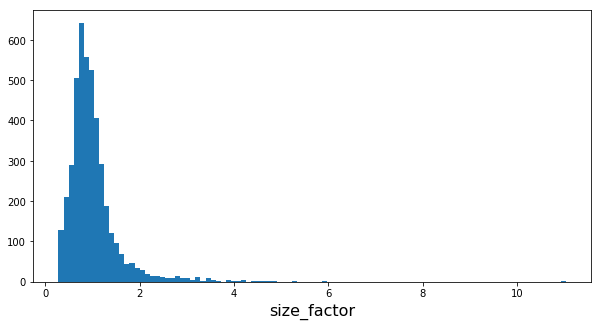

In [4]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(data)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

# Coefficient of variation (cv)
Coefficient of variation is frequently used for feature selection. The estimation of cv in *sceb* takes two steps: 
- Use sd.dd_1d_moment to estimate the moments (first two by default, but can go up to first four moments)
- Use sd.M_to_cv to convert the estimated moments to cv

In [5]:
M_ml, M_dd = sd.dd_1d_moment(data, size_factor=size_factor)
cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=4340, n_gene=4039
#total: 0.21s


# House keeping genes
It is interesting to see the estimated cv for house-keeping genes -- if the estimation is good, then house-keeping genes should have small estiamted cv. We check *11* house-keeping genes from https://www.tau.ac.il/~elieis/HKG/ 

In the figure, EB thinks 5 (out of 11) house-keeping genes have zero cv, while plug-in assigns a moderately large value for them.

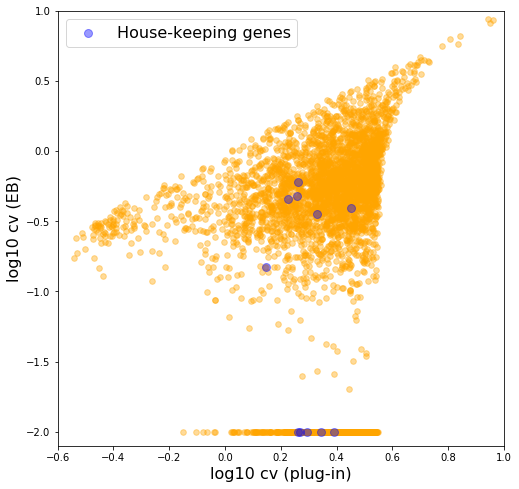

In [6]:
house_keeping_gene = np.array(['C1orf43', 'PSMB2', 'PSMB4', 'RAB7A', 'REEP5', 'VCP', 'VPS29',
                            'EMC7', 'GPI', 'CHMP2A', 'SNRPD3'], dtype=object)
ind_house_keeping = np.array([(gene in house_keeping_gene) for gene in gene_list])
# Log-scale.
log_10_cv_ml = np.log10(cv_ml)
log_10_cv_dd = np.log10(cv_dd)
# EB assigns a very small value (<1e-6) for genes which it thinks the cv is 0. Bring the 
# value of these genes back a bit for visualization purpose.
log_10_cv_dd[log_10_cv_dd<-2] = -2
# 
plt.figure(figsize=[8, 8])
plt.scatter(log_10_cv_ml, log_10_cv_dd, alpha=0.4, s=32, color='orange')
plt.scatter(log_10_cv_ml[ind_house_keeping], log_10_cv_dd[ind_house_keeping],\
            alpha=0.4, s=64, color='blue', label='House-keeping genes')
plt.xlabel('log10 cv (plug-in)', fontsize=16)
plt.ylabel('log10 cv (EB)', fontsize=16)
plt.legend(fontsize=16)
plt.xlim([-0.6, 1])
plt.ylim([-2.1, 1])
plt.show()

# Pearson correlation

In [7]:
# Estimate PC using plug-in (ml)
mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data, size_factor=size_factor,\
                                         PC_prune=False, verbose=True)

#time start: 0.0s
n_cell=4340, n_gene=4039, Nr=4038.8
#total: 28.95s
#time start: 0.0s
n_cell=4340, n_gene=4039, Nr=4038.8
#total: 28.67s


# Estimated PC for marker genes
How do estimated values look like? Let us visualize the estimated values for genes enriched in T-cells ('IL7R','CD3G','CD3E','CD3D','LCK'), NK-cells ('NKG7','PRF1','KLRD1','GZMA','HOPX','CST7') and B-cells ('CD79A','BANK1','IGHD','LINC00926','MS4A1') respctively. We should expect a block-diagonal structure.

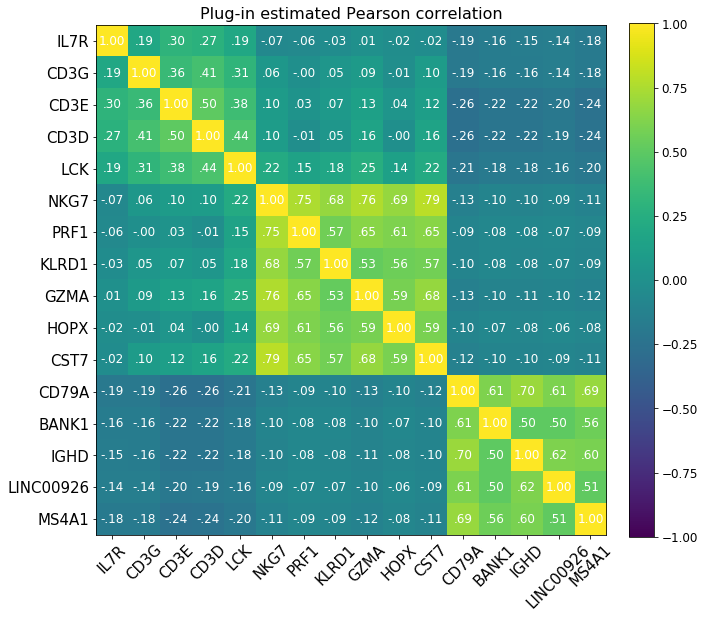

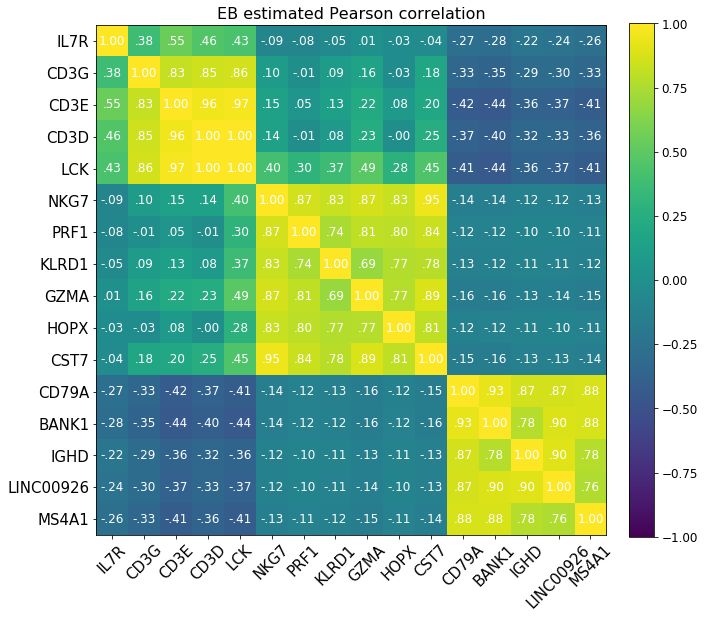

In [8]:
# Visualize the correlations for some markergenes
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']

# Plot for plug-in
plt.figure(figsize=[10, 10])
sd.marker_gene_heatmap(marker_gene_dic,gene_list,PC_ml)
plt.title('Plug-in estimated Pearson correlation', fontsize=16)
plt.show()

# Plot for EB 
plt.figure(figsize=[10, 10])
sd.marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd)
plt.title('EB estimated Pearson correlation', fontsize=16)
plt.show()

# PCA
Let us do PCA! Here we select top 1000 genes based on the estimated cv (EB and Plug-in), and then perform PCA on selected genes.

In [9]:
from sklearn.decomposition import PCA
n_gene = 1000
# EB
ind_select = np.argsort(cv_dd)[-n_gene:]
temp = np.array(data[:, ind_select].X.todense())
temp = temp.clip(max=np.percentile(temp, 99))
PCA_dd = PCA()
PCA_dd.fit(temp)
PCA_score_dd = PCA_dd.transform(temp)
# Plug-in
ind_select = np.argsort(cv_ml)[-n_gene:]
temp = np.array(data[:, ind_select].X.todense())
temp = temp.clip(max=np.percentile(temp, 99))
PCA_ml = PCA()
PCA_ml.fit(temp)
PCA_score_ml = PCA_dd.transform(temp)

EB selected features seem to contain more low-dimensional structures, as measured by the variances explained by the top PC directions.

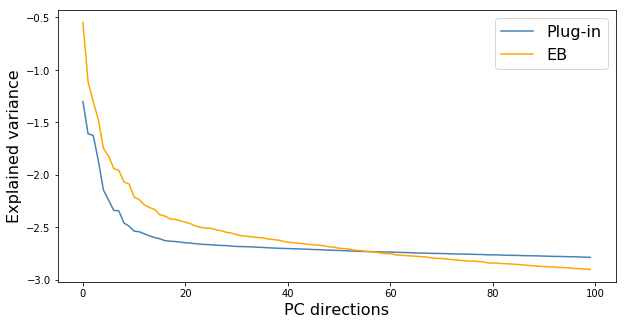

In [10]:
plt.figure(figsize=[10, 5])
plt.plot(np.log10(PCA_ml.explained_variance_ratio_[0:100]),
         color='steelblue', label='Plug-in')
plt.plot(np.log10(PCA_dd.explained_variance_ratio_[0:100]),
         color='orange', label='EB')
plt.legend(fontsize=16)
plt.xlabel('PC directions', fontsize=16)
plt.ylabel('Explained variance', fontsize=16)
plt.show()

Scatter plots of PCA scores.

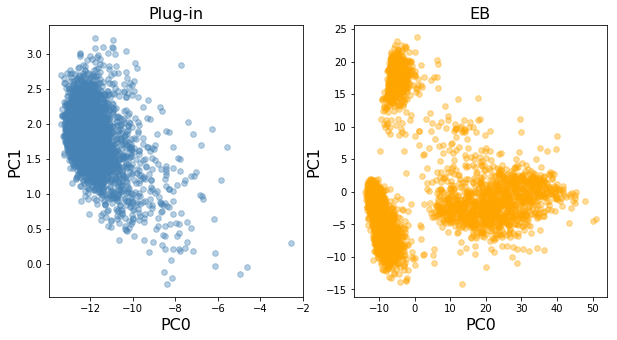

In [11]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(PCA_score_ml[:, 0], PCA_score_ml[:, 1], color='steelblue', s=32, alpha=0.4)
plt.xlabel('PC0', fontsize=16)
plt.ylabel('PC1', fontsize=16)
plt.title('Plug-in', fontsize=16)
plt.subplot(122)
plt.scatter(PCA_score_dd[:, 0], PCA_score_dd[:, 1], color='orange', s=32, alpha=0.4)
plt.xlabel('PC0', fontsize=16)
plt.ylabel('PC1', fontsize=16)
plt.title('EB', fontsize=16)
plt.show()